## Import libraries

In [43]:
import numpy as np
import open3d as o3d
from scipy.optimize import least_squares
from sklearn.cluster import DBSCAN

## Voxelize point cloud

In [58]:
pcd = o3d.io.read_point_cloud("castle.pcd")
downpcd = pcd.voxel_down_sample(voxel_size=0.000001)
points = np.asarray(downpcd.points)
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
normals = np.asarray(downpcd.normals)

In [59]:
import open3d as o3d
import numpy as np

# Load your point cloud
point_cloud = o3d.io.read_point_cloud("filtered.pcd")
point_cloud.points = o3d.utility.Vector3dVector(points)  # Replace 'points' with your point cloud data

# Estimate normals for better visualization and context (optional but useful)
point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Use Alpha Shape to create a concave hull of the point cloud (the outer boundary)
alpha = 0.0045  # Alpha value controls the tightness of the hull; adjust based on your data
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(point_cloud, alpha)

# Extract vertices (points) of the hull as the outer surface points
surface_points = np.asarray(mesh.vertices)

# Visualize the extracted surface points
surface_cloud = o3d.geometry.PointCloud()
surface_cloud.points = o3d.utility.Vector3dVector(surface_points)

# Optional: Estimate normals for the surface points for further processing or visualization
surface_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Visualize the surface points to ensure they correctly represent the outer shell
o3d.visualization.draw_geometries([surface_cloud], point_show_normal=True)

In [11]:
o3d.visualization.draw_geometries([surface_cloud], point_show_normal=True)

In [88]:
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

In [30]:
viewpoint = np.array([0, 0, 0])  # Define a suitable viewpoint outside the structure
downpcd.orient_normals_towards_camera_location(camera_location=viewpoint)

# Visualize the reoriented normals
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

In [60]:
import numpy as np
from sklearn.decomposition import PCA

# Estimate normals with tuned parameters
surface_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Convert Open3D points to NumPy array for PCA
points_np = np.asarray(downpcd.points)

# Perform PCA to find the centroid and main components
pca = PCA(n_components=1)
pca.fit(points_np)
centroid = np.mean(points_np, axis=0)

# Convert normals to NumPy array
normals_np = np.asarray(surface_cloud.normals)

# Reorient normals to point outward from the centroid
for i in range(len(normals_np)):
    normal = normals_np[i]
    vector_to_point = points_np[i] - centroid
    # Flip the normal if it is pointing inward
    if np.dot(normal, vector_to_point) < 0:
        normals_np[i] = -normal

# Update the point cloud normals with the reoriented normals
surface_cloud.normals = o3d.utility.Vector3dVector(normals_np)
normals = np.asarray(surface_cloud.normals)
points = np.asarray(surface_cloud.points)

# Visualize the reoriented normals
o3d.visualization.draw_geometries([surface_cloud], point_show_normal=True)

## RANSAC Cylinder

In [11]:
import numpy as np
from scipy.optimize import least_squares

def calculate_score(normals, axis_direction, alignment_threshold=0.5):
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    scores = np.exp(-30 * normal_alignment ** 2)
    scores[normal_alignment > alignment_threshold] = 0  # Filter out poorly aligned normals
    scores = np.clip(scores, 0, 1)

    # Only retain scores that are above zero
    filtered_scores = scores[scores > 0]
    return scores



def fit_cylinder(points, min_radius=None, max_radius=None):
    x0, y0, z0 = np.mean(points, axis=0)
    initial_axis = np.array([0, 0, 1])
    initial_radius = np.mean(np.linalg.norm(points - np.array([x0, y0, z0]), axis=1))
    initial_guess = [x0, y0, z0, *initial_axis, initial_radius]
    result = least_squares(residuals, initial_guess, args=(points,))
    return result.x  # [x0, y0, z0, a, b, c, r]

def residuals(params, points):
    x0, y0, z0, a, b, c, r = params
    axis_direction = np.array([a, b, c])
    axis_direction /= np.linalg.norm(axis_direction)
    vector_to_points = points - np.array([x0, y0, z0])
    projection_length = np.dot(vector_to_points, axis_direction)
    projection = projection_length[:, np.newaxis] * axis_direction
    perpendicular_distance = np.linalg.norm(vector_to_points - projection, axis=1)
    return perpendicular_distance - r

def expand_inliers(points, normals, initial_inliers, axis_direction, cylinder_center, radius, threshold=0.003):
    """
    Expands inliers iteratively by including nearby points that align with the current cylinder model.
    """
    expanded_inliers = initial_inliers.copy()
    for idx, point in enumerate(points):
        if idx in initial_inliers:
            continue  # Skip already included inliers
        vector_to_point = point - cylinder_center
        projection_length = np.dot(vector_to_point, axis_direction)
        projection = projection_length * axis_direction
        perpendicular_distance = np.linalg.norm(vector_to_point - projection)
        distance = np.abs(perpendicular_distance - radius)

        # Check if the point is close enough to be considered an inlier
        if distance < threshold:
            expanded_inliers.append(idx)
    return expanded_inliers

def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.3):
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Expand inliers iteratively
        expanded_inliers = expand_inliers(points, normals, initial_inliers, axis_direction, np.array([x0, y0, z0]), r, threshold)

        inlier_normals = normals[expanded_inliers]
        inlier_scores = calculate_score(inlier_normals, axis_direction, alignment_threshold)
        total_score = np.sum(inlier_scores)

        if total_score > best_score:
            best_inliers = expanded_inliers
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    best_inlier_points = points[best_inliers]
    return best_params, best_inlier_points

In [12]:
import numpy as np
from scipy.optimize import least_squares

def calculate_score(normals, axis_direction, alignment_threshold=0.1):
    """
    Calculates alignment scores based on normal vectors relative to the cylinder axis.
    The scoring function aggressively penalizes misaligned normals.
    """
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    # More aggressive scoring to emphasize alignment quality
    scores = np.exp(-50 * normal_alignment ** 2)  # Increase decay factor for stricter scoring
    # Set scores to zero if alignment is worse than the threshold
    scores[normal_alignment > alignment_threshold] = 0
    return scores

def filter_inliers_by_score(points, normals, scores, min_score_threshold=0.5):
    """
    Filters inliers based on their alignment scores, removing poorly aligned normals.
    """
    filtered_indices = scores >= min_score_threshold
    filtered_points = points[filtered_indices]
    filtered_normals = normals[filtered_indices]
    filtered_scores = scores[filtered_indices]
    return filtered_points, filtered_normals, filtered_scores

def fit_cylinder(points, min_radius=None, max_radius=None):
    """
    Fits a cylinder model to the points using least squares.
    """
    x0, y0, z0 = np.mean(points, axis=0)
    initial_axis = np.array([0, 0, 1])
    initial_radius = np.mean(np.linalg.norm(points - np.array([x0, y0, z0]), axis=1))
    initial_guess = [x0, y0, z0, *initial_axis, initial_radius]
    result = least_squares(residuals, initial_guess, args=(points,))
    return result.x  # [x0, y0, z0, a, b, c, r]

def expand_inliers(points, normals, initial_inliers, axis_direction, cylinder_center, radius, threshold=0.003):
    """
    Expands inliers iteratively by including nearby points that align with the current cylinder model,
    considering the alignment score during the expansion process.
    """
    expanded_inliers = initial_inliers.copy()
    for idx, point in enumerate(points):
        if idx in initial_inliers:
            continue  # Skip already included inliers
        vector_to_point = point - cylinder_center
        projection_length = np.dot(vector_to_point, axis_direction)
        projection = projection_length * axis_direction
        perpendicular_distance = np.linalg.norm(vector_to_point - projection)
        distance = np.abs(perpendicular_distance - radius)

        # Calculate normal alignment score
        normal_alignment = np.abs(np.dot(normals[idx], axis_direction))
        score = np.exp(-50 * normal_alignment ** 2)  # Score to filter during expansion

        # Add only if the point is close enough and well-aligned
        if distance < threshold and score > 0.5:  # Adjust the score threshold as needed
            expanded_inliers.append(idx)
    return expanded_inliers

def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1):
    """
    RANSAC algorithm for cylinder fitting with aggressive scoring, filtering, and controlled inlier expansion.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        # Check radius constraints
        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on distance to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Expand inliers iteratively with alignment considerations
        expanded_inliers = expand_inliers(points, normals, initial_inliers, axis_direction, np.array([x0, y0, z0]), r, threshold)

        # Calculate scores for the expanded inliers
        inlier_normals = normals[expanded_inliers]
        inlier_scores = calculate_score(inlier_normals, axis_direction, alignment_threshold)

        # Filter inliers based on their scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.5
        )

        total_score = np.sum(filtered_scores)

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [13]:
import numpy as np
from scipy.optimize import least_squares

def calculate_score(normals, axis_direction, alignment_threshold=0.1):
    """
    Calculates alignment scores based on normal vectors relative to the cylinder axis.
    Focuses on aggressive penalization of misalignment and enhanced rewards for good alignment.
    """
    # Normalize axis direction
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    
    # Calculate alignment score based on normal vectors
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    
    # Aggressive decay for alignment quality, emphasizing perpendicularity
    alignment_scores = np.exp(-50 * normal_alignment ** 2)  
    
    # Penalize poor alignment: Set scores to zero if alignment is beyond the threshold
    alignment_scores[normal_alignment > alignment_threshold] = 0  
    
    # Further boost scores for near-perfect alignment (close to perpendicular)
    alignment_scores = np.where(normal_alignment < 0.05, alignment_scores * 5, alignment_scores)  # Boost for near-perfect alignment
    
    return alignment_scores

def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1):
    """
    RANSAC algorithm for cylinder fitting with a refined focus on alignment scoring.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on distance to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate scores for the expanded inliers using alignment scoring
        inlier_scores = calculate_score(inlier_normals, axis_direction, alignment_threshold)

        # Filter inliers based on their alignment scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.5
        )

        total_score = np.sum(filtered_scores)

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [14]:
import numpy as np
from scipy.optimize import least_squares

def calculate_alignment_score(normals, axis_direction, alignment_threshold=0.1):
    """
    Calculates alignment scores based on normal vectors relative to the cylinder axis.
    Focuses on penalizing misalignment aggressively while rewarding good alignment.
    """
    # Normalize axis direction
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    
    # Calculate alignment score based on normal vectors
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    
    # Standard alignment scoring with aggressive decay
    alignment_scores = np.exp(-50 * normal_alignment ** 2)
    
    # Set scores to zero if alignment is worse than the threshold
    alignment_scores[normal_alignment > alignment_threshold] = 0  
    
    return alignment_scores

def evaluate_distribution_uniformity(points, cylinder_center, axis_direction, segments=12):
    """
    Evaluates the distribution uniformity of inliers around a cylinder by dividing the circumference
    into angular segments and assessing how evenly the inliers are distributed.
    
    Parameters:
        points (ndarray): Array of inlier points.
        cylinder_center (ndarray): Center point of the cylinder.
        axis_direction (ndarray): Direction vector of the cylinder axis.
        segments (int): Number of angular segments to divide the circumference into.

    Returns:
        uniformity_score (float): A score representing how uniformly distributed the points are.
    """
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    vectors_to_points = points - cylinder_center
    # Project points onto a plane perpendicular to the cylinder axis
    projections = vectors_to_points - np.dot(vectors_to_points, axis_direction)[:, np.newaxis] * axis_direction
    
    # Calculate angles of the projected points around the cylinder axis
    angles = np.arctan2(projections[:, 1], projections[:, 0])
    
    # Divide angles into segments and count points in each segment
    segment_counts, _ = np.histogram(angles, bins=segments, range=(-np.pi, np.pi))
    
    # Calculate the standard deviation of the segment counts
    ideal_count = len(points) / segments
    deviation = np.std(segment_counts - ideal_count)
    
    # Inverse of deviation: lower deviation means more uniform distribution
    uniformity_score = np.exp(-deviation)  # Higher score for more uniform distribution
    
    return uniformity_score

def calculate_combined_score(normals, axis_direction, points, cylinder_center, uniformity_weight=0.5, alignment_threshold=0.1):
    """
    Combines alignment scoring with a distribution uniformity score to enhance the evaluation of inliers.
    """
    alignment_scores = calculate_alignment_score(normals, axis_direction, alignment_threshold)
    uniformity_score = evaluate_distribution_uniformity(points, cylinder_center, axis_direction)

    # Combine alignment and uniformity scores with a weighted approach
    combined_scores = alignment_scores * (1 + uniformity_weight * uniformity_score)
    return combined_scores

def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1):
    """
    RANSAC algorithm for cylinder fitting with a focus on alignment scoring and distribution uniformity.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on distance to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate combined scores for the expanded inliers using alignment and uniformity
        cylinder_center = np.array([x0, y0, z0])
        inlier_scores = calculate_combined_score(inlier_normals, axis_direction, points[expanded_inliers], cylinder_center, alignment_threshold=alignment_threshold)

        # Filter inliers based on their combined scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.3
        )

        total_score = np.sum(filtered_scores)

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [15]:
def fit_cylinder(points, min_radius=None, max_radius=None):
    """
    Fits a cylinder model to the points using least squares.
    """
    x0, y0, z0 = np.mean(points, axis=0)
    initial_axis = np.array([0, 0, 1])  # Initial guess for axis direction
    initial_radius = np.mean(np.linalg.norm(points - np.array([x0, y0, z0]), axis=1))
    initial_guess = [x0, y0, z0, *initial_axis, initial_radius]

    result = least_squares(residuals, initial_guess, args=(points,))
    x0, y0, z0, a, b, c, r = result.x
    
    # Correct the axis direction to ensure it points outward
    axis_direction = np.array([a, b, c])
    axis_direction /= np.linalg.norm(axis_direction)
    
    # Define a reference point on the axis (e.g., cylinder base)
    cylinder_center = np.array([x0, y0, z0])
    
    # Use the first point in the inliers to determine direction
    surface_point = points[0]  # This could be any representative surface point
    
    # Vector from the cylinder center to the surface point
    vector_to_surface = surface_point - cylinder_center
    
    # Check if the axis direction is pointing inward and flip if necessary
    if np.dot(axis_direction, vector_to_surface) < 0:
        axis_direction = -axis_direction  # Flip the axis direction
    
    # Return the corrected parameters
    return [x0, y0, z0, *axis_direction, r]

# Example integration in RANSAC
def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1):
    """
    RANSAC algorithm for cylinder fitting with a focus on alignment scoring and distribution uniformity.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on distance to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate combined scores for the expanded inliers using alignment and uniformity
        cylinder_center = np.array([x0, y0, z0])
        inlier_scores = calculate_combined_score(inlier_normals, axis_direction, points[expanded_inliers], cylinder_center, alignment_threshold=alignment_threshold)

        # Filter inliers based on their combined scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.3
        )

        total_score = np.sum(filtered_scores)

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [57]:
import numpy as np
from scipy.optimize import least_squares

def calculate_continuity_score(points, axis_direction, cylinder_center):
    """
    Evaluates the continuity of inliers along the cylinder axis by checking for gaps between points.
    Penalizes large or frequent gaps, leading to a lower continuity score.
    """
    # Project points onto the cylinder axis
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    vectors_to_points = points - cylinder_center
    projection_lengths = np.dot(vectors_to_points, axis_direction)
    
    # Sort the projection lengths to evaluate continuity along the axis
    sorted_projections = np.sort(projection_lengths)
    
    # Calculate the gaps between sequential projected points
    gaps = np.diff(sorted_projections)
    mean_gap = np.mean(gaps)
    max_gap = np.max(gaps)
    
    # Penalize based on the size and variability of gaps
    continuity_score = np.exp(-10 * (max_gap + mean_gap))  # Larger gaps result in lower continuity scores
    
    return continuity_score

def calculate_combined_score(normals, axis_direction, points, cylinder_center, continuity_weight=0.5, alignment_threshold=0.1):
    """
    Combines alignment scoring, distribution uniformity, and continuity score to enhance the evaluation of inliers.
    """
    # Calculate alignment scores
    alignment_scores = calculate_alignment_score(normals, axis_direction, alignment_threshold)
    
    # Calculate uniformity score based on how well the inliers cover the cylinder circumference
    uniformity_score = evaluate_distribution_uniformity(points, cylinder_center, axis_direction)
    
    # Calculate continuity score based on gaps along the cylinder axis
    continuity_score = calculate_continuity_score(points, axis_direction, cylinder_center)
    
    # Combine alignment, uniformity, and continuity scores with weighted adjustments
    combined_scores = alignment_scores * (1 + continuity_weight * uniformity_score) * continuity_score
    
    return combined_scores

def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1):
    """
    RANSAC algorithm for cylinder fitting with a focus on alignment scoring, distribution uniformity, and continuity penalties.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on distance to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate combined scores for the expanded inliers including continuity penalties
        cylinder_center = np.array([x0, y0, z0])
        inlier_scores = calculate_combined_score(inlier_normals, axis_direction, points[expanded_inliers], cylinder_center, alignment_threshold=alignment_threshold)

        # Filter inliers based on their combined scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.3
        )

        total_score = np.sum(filtered_scores)

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers


In [17]:
import numpy as np
from scipy.optimize import least_squares

def fit_partial_cylinder(points, min_radius=None, max_radius=None):
    """
    Fits a cylinder model to a subset of points using least squares, optimized for partial cylinders.
    """
    x0, y0, z0 = np.mean(points, axis=0)
    initial_axis = np.array([0, 0, 1])  # Example initial guess for the axis direction
    initial_radius = np.mean(np.linalg.norm(points - np.array([x0, y0, z0]), axis=1))
    initial_guess = [x0, y0, z0, *initial_axis, initial_radius]

    result = least_squares(residuals, initial_guess, args=(points,))
    x0, y0, z0, a, b, c, r = result.x
    
    # Normalize axis direction
    axis_direction = np.array([a, b, c]) / np.linalg.norm([a, b, c])
    
    # Ensure the axis points outward
    cylinder_center = np.array([x0, y0, z0])
    surface_point = points[0]  # Choose a representative surface point
    vector_to_surface = surface_point - cylinder_center
    if np.dot(axis_direction, vector_to_surface) < 0:
        axis_direction = -axis_direction  # Flip if pointing inward
    
    return [x0, y0, z0, *axis_direction, r]

def ransac_partial_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.000000000001):
    """
    RANSAC algorithm optimized for fitting partial cylinders, focusing on the best available data.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a partial cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_partial_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on proximity to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate alignment scores for the inliers
        cylinder_center = np.array([x0, y0, z0])
        inlier_scores = calculate_alignment_score(inlier_normals, axis_direction, alignment_threshold)

        # Filter inliers based on their scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.3
        )

        total_score = np.sum(filtered_scores)

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

def calculate_score(normals, axis_direction, alignment_threshold=0.1):
    """
    Calculates alignment scores based on normal vectors relative to the cylinder axis.
    Aggressively penalizes misalignment and rewards good alignment.
    """
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    
    # Calculate alignment scores with an aggressive penalty for misalignment
    scores = np.exp(-50 * normal_alignment ** 2)
    
    # Visualize the score distribution to understand the spread
    plt.hist(scores, bins=50, color='blue', alpha=0.7)
    plt.title('Alignment Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

    # Set scores to zero if the alignment is worse than the threshold
    scores[normal_alignment > alignment_threshold] = 0  
    return scores

def filter_inliers_by_score(points, normals, scores, min_score_threshold=0.3):
    """
    Filters inliers based on a minimum score threshold, removing poorly aligned normals.
    """
    # Ensure that scores are filtered based on the provided threshold
    filtered_indices = scores >= min_score_threshold
    filtered_points = points[filtered_indices]
    filtered_normals = normals[filtered_indices]
    filtered_scores = scores[filtered_indices]
    
    # Print the number of filtered points to verify filtering effectiveness
    print(f"Number of inliers after filtering: {len(filtered_points)} / {len(points)}")
    
    return filtered_points, filtered_normals, filtered_scores

# Example use in RANSAC
def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1):
    """
    RANSAC algorithm optimized for fitting partial cylinders, focusing on the best available data.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a partial cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on proximity to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate alignment scores for the inliers and visualize
        cylinder_center = np.array([x0, y0, z0])
        inlier_scores = calculate_score(inlier_normals, axis_direction, alignment_threshold)

        # Filter inliers based on their scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.3
        )

        total_score = np.sum(filtered_scores)

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

def calculate_score(normals, axis_direction, alignment_threshold=0.1):
    """
    Calculates alignment scores based on normal vectors relative to the cylinder axis.
    Aggressively penalizes misalignment and rewards good alignment.
    """
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    
    # Calculate alignment scores with an aggressive penalty for misalignment
    scores = np.exp(-50 * normal_alignment ** 2)
    
    # Visualize the score distribution to understand the spread
    plt.hist(scores, bins=50, color='blue', alpha=0.7)
    plt.title('Alignment Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

    # Set scores to zero if the alignment is worse than the threshold
    scores[normal_alignment > alignment_threshold] = 0  
    return scores

def filter_inliers_by_score(points, normals, scores, min_score_threshold=0.3):
    """
    Filters inliers based on a minimum score threshold, removing poorly aligned normals.
    """
    # Ensure that scores are filtered based on the provided threshold
    filtered_indices = scores >= min_score_threshold
    filtered_points = points[filtered_indices]
    filtered_normals = normals[filtered_indices]
    filtered_scores = scores[filtered_indices]
    
    # Print the number of filtered points to verify filtering effectiveness
    print(f"Number of inliers after filtering: {len(filtered_points)} / {len(points)}")
    
    return filtered_points, filtered_normals, filtered_scores

# Main RANSAC function
def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1):
    """
    RANSAC algorithm optimized for fitting partial cylinders, focusing on the best available data.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a partial cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on proximity to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate alignment scores for the inliers
        cylinder_center = np.array([x0, y0, z0])
        inlier_scores = calculate_score(inlier_normals, axis_direction, alignment_threshold)

        # Filter inliers based on their scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.1
        )

        # Only consider filtered points and scores in the final evaluation
        if len(filtered_points) == 0:  # Skip if no inliers remain after filtering
            continue

        total_score = np.sum(filtered_scores)

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [20]:
def calculate_score(normals, axis_direction, alignment_threshold=0.1):
    """
    Calculates alignment scores based on normal vectors relative to the cylinder axis.
    Aggressively penalizes misalignment and rewards good alignment.
    """
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    
    # Calculate alignment scores with an aggressive penalty for misalignment
    scores = np.exp(-50 * normal_alignment ** 2)

    # Set scores to zero if the alignment is worse than the threshold
    scores[normal_alignment > alignment_threshold] = 0  
    return scores

def filter_inliers_by_score(points, normals, scores, min_score_threshold=0.3):
    """
    Filters inliers based on a minimum score threshold, removing poorly aligned normals.
    """
    # Ensure that scores are filtered based on the provided threshold
    filtered_indices = scores >= min_score_threshold
    filtered_points = points[filtered_indices]
    filtered_normals = normals[filtered_indices]
    filtered_scores = scores[filtered_indices]
    
    # Print the number of filtered points to verify filtering effectiveness
    print(f"Number of inliers after filtering: {len(filtered_points)} / {len(points)}")
    
    # Visualize the score distribution of the filtered scores
    plt.hist(filtered_scores, bins=50, color='blue', alpha=0.7)
    plt.title('Filtered Alignment Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

    return filtered_points, filtered_normals, filtered_scores


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

def calculate_score(normals, axis_direction, alignment_threshold=0.1):
    """
    Calculates alignment scores based on normal vectors relative to the cylinder axis.
    Aggressively penalizes misalignment and rewards good alignment.
    """
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    
    # Calculate alignment scores with an aggressive penalty for misalignment
    scores = np.exp(-50 * normal_alignment ** 2)

    # Set scores to zero if the alignment is worse than the threshold
    scores[normal_alignment > alignment_threshold] = 0  
    return scores

def filter_inliers_by_score(points, normals, scores, min_score_threshold=0.3):
    """
    Filters inliers based on a minimum score threshold, removing poorly aligned normals.
    """
    # Ensure that scores are filtered based on the provided threshold
    filtered_indices = scores >= min_score_threshold
    filtered_points = points[filtered_indices]
    filtered_normals = normals[filtered_indices]
    filtered_scores = scores[filtered_indices]
    
    # Print the number of filtered points to verify filtering effectiveness
    print(f"Number of inliers after filtering: {len(filtered_points)} / {len(points)}")
    
    return filtered_points, filtered_normals, filtered_scores

def check_continuity(points, axis_direction, cylinder_center, max_gap_threshold=0.05):
    """
    Checks the continuity of inliers along the cylinder axis by measuring gaps between sequential points.
    Rejects cylinders if the maximum gap exceeds the specified threshold.
    
    Parameters:
        points (ndarray): Inlier points.
        axis_direction (ndarray): Cylinder axis direction.
        cylinder_center (ndarray): Center of the cylinder.
        max_gap_threshold (float): Maximum allowed gap between points to consider the cylinder continuous.
        
    Returns:
        is_continuous (bool): True if the cylinder is continuous, False if gaps exceed the threshold.
    """
    # Project points onto the cylinder axis
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    vectors_to_points = points - cylinder_center
    projection_lengths = np.dot(vectors_to_points, axis_direction)
    
    # Sort the projection lengths to evaluate continuity along the axis
    sorted_projections = np.sort(projection_lengths)
    
    # Calculate the gaps between sequential projected points
    gaps = np.diff(sorted_projections)
    max_gap = np.max(gaps)
    
    # Check if the largest gap is within the allowed threshold
    is_continuous = max_gap <= max_gap_threshold
    return is_continuous

def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1, max_gap_threshold=0.05):
    """
    RANSAC algorithm optimized for fitting partial cylinders, focusing on the best available data.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a partial cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on proximity to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate alignment scores for the inliers
        cylinder_center = np.array([x0, y0, z0])
        inlier_scores = calculate_score(inlier_normals, axis_direction, alignment_threshold)

        # Filter inliers based on their scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.9
        )

        # Check if the filtered inliers are continuous
        if not check_continuity(filtered_points, axis_direction, cylinder_center, max_gap_threshold):
            print("Inliers are not continuous, skipping this model.")
            continue  # Skip this model if continuity is not satisfied

        # Only consider filtered points and scores in the final evaluation
        if len(filtered_points) == 0:  # Skip if no inliers remain after filtering
            continue

        total_score = np.sum(filtered_scores)

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [22]:
def check_continuity(points, axis_direction, cylinder_center, max_gap_threshold=0.05):
    """
    Checks the continuity of inliers along the cylinder axis by measuring gaps between sequential points.
    Rejects cylinders if the maximum gap exceeds the specified threshold.

    Parameters:
        points (ndarray): Inlier points.
        axis_direction (ndarray): Cylinder axis direction.
        cylinder_center (ndarray): Center of the cylinder.
        max_gap_threshold (float): Maximum allowed gap between points to consider the cylinder continuous.

    Returns:
        is_continuous (bool): True if the cylinder is continuous, False if gaps exceed the threshold.
    """
    # Project points onto the cylinder axis
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    vectors_to_points = points - cylinder_center
    projection_lengths = np.dot(vectors_to_points, axis_direction)

    # Sort the projection lengths to evaluate continuity along the axis
    sorted_projections = np.sort(projection_lengths)

    # Calculate the gaps between sequential projected points
    gaps = np.diff(sorted_projections)

    # Check if gaps are empty and handle it safely
    if gaps.size == 0:
        print("Insufficient points for continuity check. Skipping this model.")
        return False  # Assume discontinuous if gaps can't be evaluated

    max_gap = np.max(gaps)

    # Check if the largest gap is within the allowed threshold
    is_continuous = max_gap <= max_gap_threshold
    return is_continuous

In [23]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def calculate_score(normals, axis_direction, alignment_threshold=0.1):
    """
    Calculates alignment scores based on normal vectors relative to the cylinder axis.
    Aggressively penalizes misalignment and rewards good alignment.
    """
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    
    # Calculate alignment scores with an aggressive penalty for misalignment
    scores = np.exp(-50 * normal_alignment ** 2)

    # Set scores to zero if the alignment is worse than the threshold
    scores[normal_alignment > alignment_threshold] = 0  
    return scores

def evaluate_spread_penalty(points, axis_direction):
    """
    Evaluates the spread of inliers along the cylinder axis and applies a penalty
    if the inliers are concentrated in a small region.
    
    Parameters:
        points (ndarray): Inlier points.
        axis_direction (ndarray): Cylinder axis direction.
        
    Returns:
        spread_penalty (float): A penalty factor based on the spread of the inliers.
                                Lower spread leads to a higher penalty.
    """
    # Project points onto the cylinder axis
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    projections = np.dot(points - np.mean(points, axis=0), axis_direction)
    
    # Calculate the spread (range) of the projected points
    spread = np.max(projections) - np.min(projections)
    
    # Define a spread penalty factor: lower spread means higher penalty
    # You can adjust the penalty sensitivity by tweaking this function
    spread_penalty = np.exp(-spread * 10)  # Exponential penalty to enhance the effect of small spreads
    return spread_penalty

def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1):
    """
    RANSAC algorithm optimized for fitting partial cylinders, focusing on the best available data.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a partial cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on proximity to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate alignment scores for the inliers
        inlier_scores = calculate_score(inlier_normals, axis_direction, alignment_threshold)

        # Filter inliers based on their scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.3
        )

        # Calculate the spread penalty based on the distribution of filtered inliers
        spread_penalty = evaluate_spread_penalty(filtered_points, axis_direction)

        # Only consider filtered points and scores in the final evaluation
        if len(filtered_points) == 0:
            continue

        # Adjust the total score with the spread penalty
        total_score = np.sum(filtered_scores) * spread_penalty

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [47]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def calculate_score(normals, axis_direction, alignment_threshold=0.1):
    """
    Calculates alignment scores based on normal vectors relative to the cylinder axis.
    Aggressively penalizes misalignment and rewards good alignment.
    """
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    normal_alignment = np.abs(np.dot(normals, axis_direction))
    
    # Calculate alignment scores with an aggressive penalty for misalignment
    scores = np.exp(-50 * normal_alignment ** 2)

    # Set scores to zero if the alignment is worse than the threshold
    scores[normal_alignment > alignment_threshold] = 0  
    return scores

def evaluate_angular_coverage(points, axis_direction, cylinder_center, min_coverage=0.8):
    """
    Evaluates the angular coverage of inliers around the cylinder axis.
    Scores the model based on how close the inliers are to forming a full 360-degree circle.

    Parameters:
        points (ndarray): Inlier points.
        axis_direction (ndarray): Cylinder axis direction.
        cylinder_center (ndarray): Center of the cylinder.
        min_coverage (float): Minimum desired angular coverage as a fraction of 360 degrees.

    Returns:
        angular_score (float): A score penalizing models that do not achieve sufficient angular coverage.
    """
    # Project inliers onto a plane perpendicular to the cylinder axis
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    vectors_to_points = points - cylinder_center
    # Create an orthogonal basis with axis_direction
    basis1 = np.cross(axis_direction, [1, 0, 0])
    if np.linalg.norm(basis1) < 1e-6:  # If axis_direction is aligned with x-axis, choose another basis
        basis1 = np.cross(axis_direction, [0, 1, 0])
    basis1 /= np.linalg.norm(basis1)
    basis2 = np.cross(axis_direction, basis1)

    # Project points onto the orthogonal plane
    projections = np.dot(vectors_to_points, np.column_stack((basis1, basis2)))

    # Convert projections to polar coordinates (angles)
    angles = np.arctan2(projections[:, 1], projections[:, 0])
    angles = np.unwrap(angles)  # Unwrap to prevent discontinuities

    # Calculate the angular range covered
    angular_coverage = (np.max(angles) - np.min(angles)) / (2 * np.pi)  # Fraction of 360 degrees

    # Calculate the score based on how much of 360 degrees is covered
    angular_score = min(1, angular_coverage / min_coverage)  # Score is capped at 1 for full coverage
    return angular_score

def ransac_cylinder(points, normals, threshold, iterations, min_radius=None, max_radius=None, alignment_threshold=0.1, min_angular_coverage=0.8):
    """
    RANSAC algorithm optimized for fitting partial cylinders, focusing on the best available data.
    """
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")
        # Randomly sample points to fit a partial cylinder
        sample = points[np.random.choice(points.shape[0], 5, replace=False)]
        params = fit_cylinder(sample, min_radius, max_radius)
        x0, y0, z0, a, b, c, r = params

        if (min_radius is not None and r < min_radius) or (max_radius is not None and r > max_radius):
            continue

        axis_direction = np.array([a, b, c])
        axis_direction /= np.linalg.norm(axis_direction)
        initial_inliers = []

        # Evaluate inliers based on proximity to the cylinder model
        for idx, point in enumerate(points):
            vector_to_point = point - np.array([x0, y0, z0])
            projection_length = np.dot(vector_to_point, axis_direction)
            projection = projection_length * axis_direction
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            distance = np.abs(perpendicular_distance - r)

            if distance < threshold:
                initial_inliers.append(idx)

        # Extract normals of the inliers
        expanded_inliers = np.array(initial_inliers)
        inlier_normals = normals[expanded_inliers]

        # Calculate alignment scores for the inliers
        cylinder_center = np.array([x0, y0, z0])
        inlier_scores = calculate_score(inlier_normals, axis_direction, alignment_threshold)

        # Filter inliers based on their scores
        filtered_points, filtered_normals, filtered_scores = filter_inliers_by_score(
            points[expanded_inliers], inlier_normals, inlier_scores, min_score_threshold=0.3
        )

        # Evaluate angular coverage
        angular_score = evaluate_angular_coverage_with_clustering(points, axis_direction, cylinder_center, min_coverage=0.8, max_gap_fraction=0.1, min_clusters=1)

        # Only consider filtered points and scores in the final evaluation
        if len(filtered_points) == 0:
            continue

        # Adjust the total score with the angular coverage score
        total_score = np.sum(filtered_scores) * angular_score

        # Update best model if this fit has a higher score
        if total_score > best_score:
            best_inliers = filtered_points
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    return best_params, best_inliers

In [27]:
from sklearn.cluster import DBSCAN

def evaluate_angular_coverage(points, axis_direction, cylinder_center, min_coverage=0.8, max_gap_fraction=0.1):
    """
    Evaluates the angular coverage of inliers around the cylinder axis.
    Scores the model based on how close the inliers are to forming a full 360-degree circle and penalizes gaps.

    Parameters:
        points (ndarray): Inlier points.
        axis_direction (ndarray): Cylinder axis direction.
        cylinder_center (ndarray): Center of the cylinder.
        min_coverage (float): Minimum desired angular coverage as a fraction of 360 degrees.
        max_gap_fraction (float): Maximum allowed fraction of 360 degrees for any gap.

    Returns:
        angular_score (float): A score penalizing models that do not achieve sufficient angular coverage.
    """
    # Project inliers onto a plane perpendicular to the cylinder axis
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    vectors_to_points = points - cylinder_center
    basis1 = np.cross(axis_direction, [1, 0, 0])
    if np.linalg.norm(basis1) < 1e-6:  # If axis_direction is aligned with x-axis, choose another basis
        basis1 = np.cross(axis_direction, [0, 1, 0])
    basis1 /= np.linalg.norm(basis1)
    basis2 = np.cross(axis_direction, basis1)

    # Project points onto the orthogonal plane
    projections = np.dot(vectors_to_points, np.column_stack((basis1, basis2)))

    # Convert projections to polar coordinates (angles)
    angles = np.arctan2(projections[:, 1], projections[:, 0])
    angles = np.sort(np.unwrap(angles))  # Sort and unwrap to prevent discontinuities

    # Calculate the angular range covered and detect gaps
    angular_coverage = (np.max(angles) - np.min(angles)) / (2 * np.pi)  # Fraction of 360 degrees

    # Detect gaps between sorted angles
    angle_diffs = np.diff(angles)
    max_gap = np.max(angle_diffs) / (2 * np.pi)  # Max gap as a fraction of 360 degrees

    # Penalize based on the largest gap detected
    if max_gap > max_gap_fraction:
        print(f"Large angular gap detected: {max_gap * 360:.2f} degrees.")
        angular_score = 0  # Assign a low score due to large gaps
    else:
        # Calculate the score based on how much of 360 degrees is covered
        angular_score = min(1, angular_coverage / min_coverage)  # Score is capped at 1 for full coverage

    return angular_score


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_angular_coverage(points, axis_direction, cylinder_center, min_coverage=0.8, max_gap_fraction=0.1):
    """
    Evaluates the angular coverage of inliers around the cylinder axis.
    Scores the model based on how close the inliers are to forming a full 360-degree circle and penalizes gaps.

    Parameters:
        points (ndarray): Inlier points.
        axis_direction (ndarray): Cylinder axis direction.
        cylinder_center (ndarray): Center of the cylinder.
        min_coverage (float): Minimum desired angular coverage as a fraction of 360 degrees.
        max_gap_fraction (float): Maximum allowed fraction of 360 degrees for any gap.

    Returns:
        angular_score (float): A score penalizing models that do not achieve sufficient angular coverage.
    """
    # Project inliers onto a plane perpendicular to the cylinder axis
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    vectors_to_points = points - cylinder_center
    basis1 = np.cross(axis_direction, [1, 0, 0])
    if np.linalg.norm(basis1) < 1e-6:  # If axis_direction is aligned with x-axis, choose another basis
        basis1 = np.cross(axis_direction, [0, 1, 0])
    basis1 /= np.linalg.norm(basis1)
    basis2 = np.cross(axis_direction, basis1)

    # Project points onto the orthogonal plane
    projections = np.dot(vectors_to_points, np.column_stack((basis1, basis2)))

    # Convert projections to polar coordinates (angles)
    angles = np.arctan2(projections[:, 1], projections[:, 0])
    angles = np.sort(np.unwrap(angles))  # Sort and unwrap to prevent discontinuities

    # Calculate the angular range covered and detect gaps
    angular_coverage = (np.max(angles) - np.min(angles)) / (2 * np.pi)  # Fraction of 360 degrees

    # Detect gaps between sorted angles
    angle_diffs = np.diff(angles)
    max_gap = np.max(angle_diffs) / (2 * np.pi)  # Max gap as a fraction of 360 degrees

    # Visualize the angular distribution and gaps
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(angles, np.zeros_like(angles), 'o', color='blue')
    plt.title("Angular Distribution of Inliers")
    plt.xlabel("Angle (radians)")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(angle_diffs, bins=30, color='red', alpha=0.7)
    plt.title("Gaps Between Consecutive Angles")
    plt.xlabel("Gap Size (radians)")
    plt.ylabel("Frequency")
    plt.axvline(max_gap * 2 * np.pi, color='red', linestyle='--', label=f'Max Gap: {max_gap * 360:.1f}°')
    plt.legend()
    plt.show()

    # Penalize based on the largest gap detected
    if max_gap > max_gap_fraction:
        print(f"Large angular gap detected: {max_gap * 360:.2f} degrees.")
        angular_score = 0  # Assign a low score due to large gaps
    else:
        # Calculate the score based on how much of 360 degrees is covered
        angular_score = min(1, angular_coverage / min_coverage)  # Score is capped at 1 for full coverage

    return angular_score

In [37]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

def evaluate_angular_coverage_with_clustering(points, axis_direction, cylinder_center, min_coverage=0.8, max_gap_fraction=0.1, min_clusters=1):
    """
    Evaluates the angular coverage of inliers around the cylinder axis using clustering.
    Scores the model based on how close the inliers are to forming a full 360-degree circle and penalizes gaps and clusters.

    Parameters:
        points (ndarray): Inlier points.
        axis_direction (ndarray): Cylinder axis direction.
        cylinder_center (ndarray): Center of the cylinder.
        min_coverage (float): Minimum desired angular coverage as a fraction of 360 degrees.
        max_gap_fraction (float): Maximum allowed fraction of 360 degrees for any gap.
        min_clusters (int): Minimum number of clusters expected around the circle.

    Returns:
        angular_score (float): A score penalizing models that do not achieve sufficient angular coverage.
    """
    # Project inliers onto a plane perpendicular to the cylinder axis
    axis_direction = axis_direction / np.linalg.norm(axis_direction)
    vectors_to_points = points - cylinder_center
    basis1 = np.cross(axis_direction, [1, 0, 0])
    if np.linalg.norm(basis1) < 1e-6:  # If axis_direction is aligned with x-axis, choose another basis
        basis1 = np.cross(axis_direction, [0, 1, 0])
    basis1 /= np.linalg.norm(basis1)
    basis2 = np.cross(axis_direction, basis1)

    # Project points onto the orthogonal plane
    projections = np.dot(vectors_to_points, np.column_stack((basis1, basis2)))

    # Convert projections to polar coordinates (angles)
    angles = np.arctan2(projections[:, 1], projections[:, 0])
    angles = np.sort(np.unwrap(angles))  # Sort and unwrap to prevent discontinuities

    # Clustering of angles to detect clusters and gaps
    angle_diffs = np.diff(angles)
    db = DBSCAN(eps=max_gap_fraction * 2 * np.pi, min_samples=3).fit(angles.reshape(-1, 1))

    # Calculate the angular range covered and number of clusters
    angular_coverage = (np.max(angles) - np.min(angles)) / (2 * np.pi)  # Fraction of 360 degrees
    num_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)  # Count clusters excluding noise

    # Visualize the angular distribution and clusters
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(angles, np.zeros_like(angles), 'o', color='blue')
    plt.title("Angular Distribution of Inliers")
    plt.xlabel("Angle (radians)")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(angle_diffs, bins=30, color='red', alpha=0.7)
    plt.title("Gaps Between Consecutive Angles")
    plt.xlabel("Gap Size (radians)")
    plt.ylabel("Frequency")
    plt.axvline(max_gap_fraction * 2 * np.pi, color='red', linestyle='--', label=f'Max Gap Threshold')
    plt.legend()
    plt.show()

    # Penalize models based on the cluster and gap analysis
    if angular_coverage < min_coverage or num_clusters < min_clusters:
        print(f"Insufficient angular coverage or clusters detected: Coverage = {angular_coverage * 360:.2f} degrees, Clusters = {num_clusters}.")
        angular_score = 0  # Assign a low score due to insufficient coverage or clustering
    else:
        angular_score = min(1, angular_coverage / min_coverage)  # Score is capped at 1 for full coverage

    return angular_score

## Run RANSAC

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Number of inliers after filtering: 137 / 1012


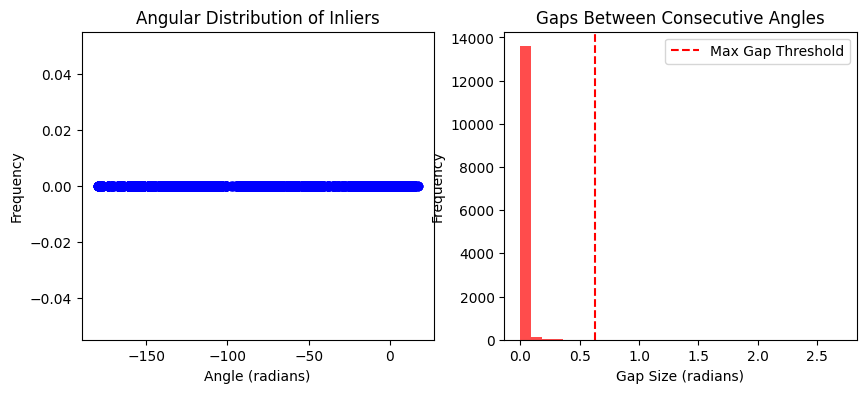

Iteration: 5
Iteration: 6
Number of inliers after filtering: 161 / 760


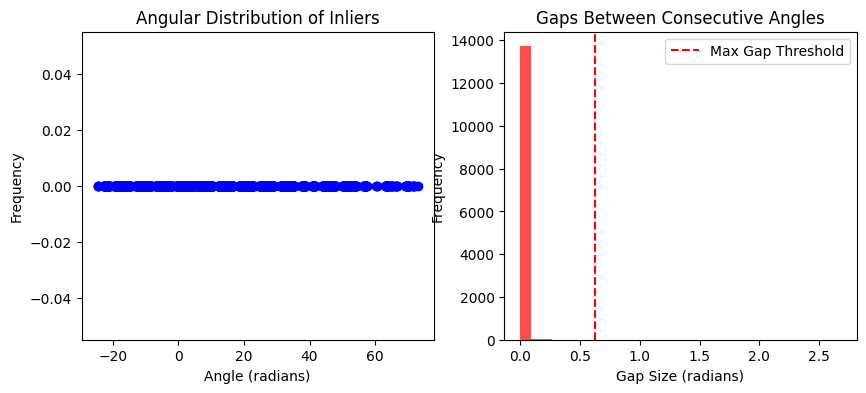

Iteration: 7
Iteration: 8
Iteration: 9
Number of inliers after filtering: 162 / 756


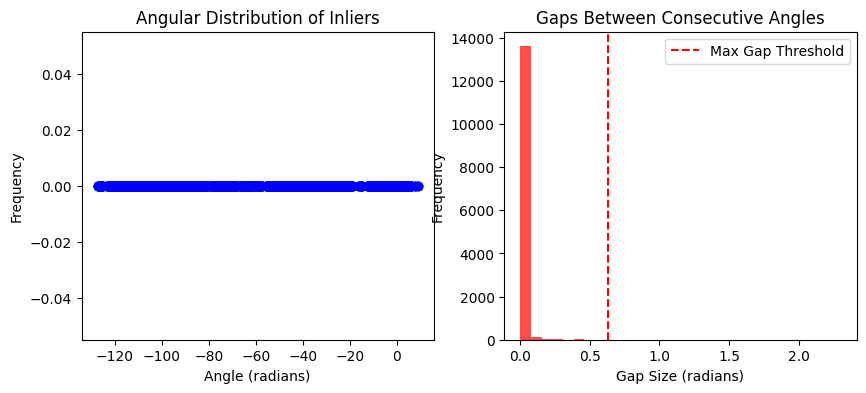

Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Number of inliers after filtering: 96 / 921


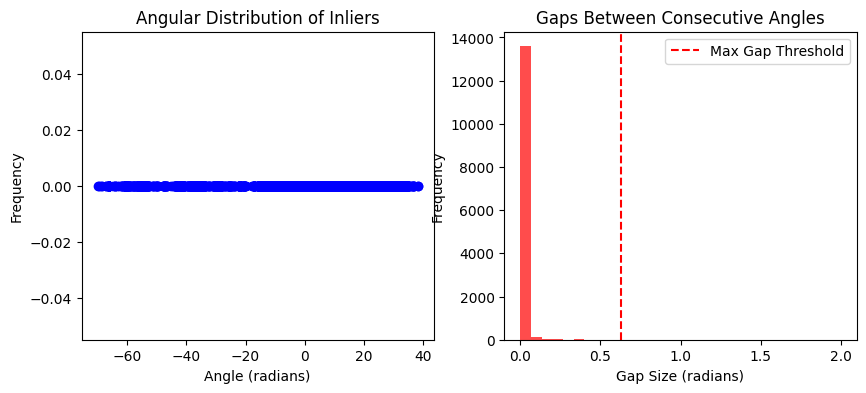

Iteration: 15
Number of inliers after filtering: 64 / 871


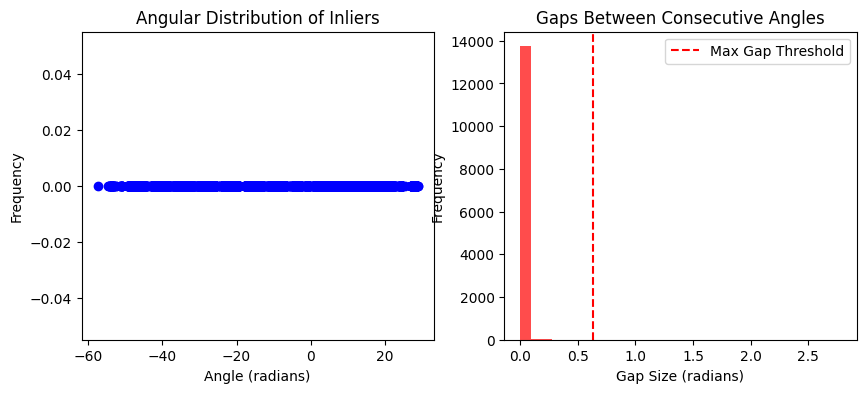

Iteration: 16
Iteration: 17
Number of inliers after filtering: 71 / 1104


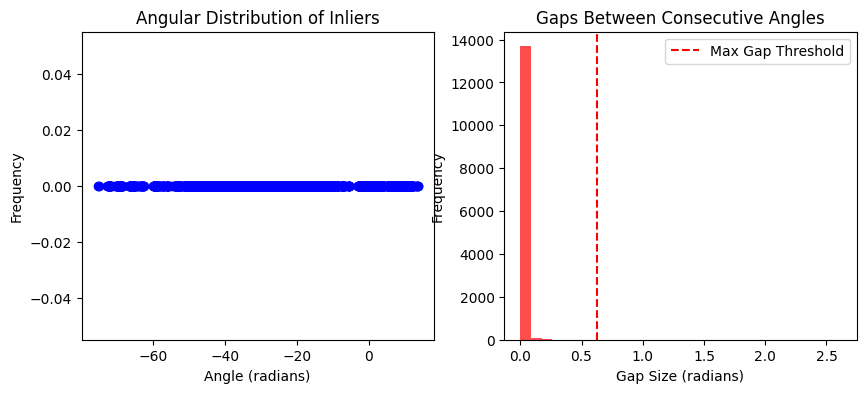

Iteration: 18
Number of inliers after filtering: 56 / 772


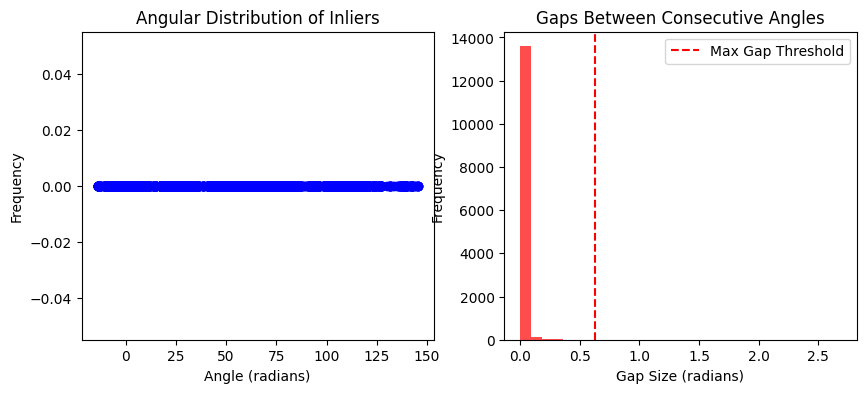

Iteration: 19
Iteration: 20
Iteration: 21
Number of inliers after filtering: 58 / 959


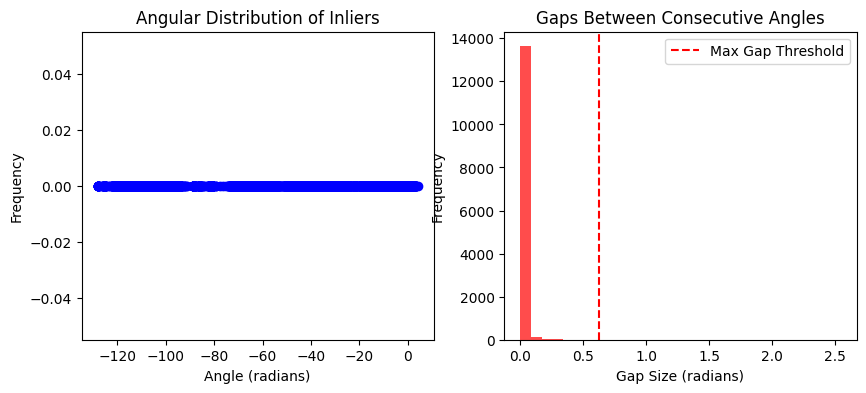

Iteration: 22
Number of inliers after filtering: 129 / 1056


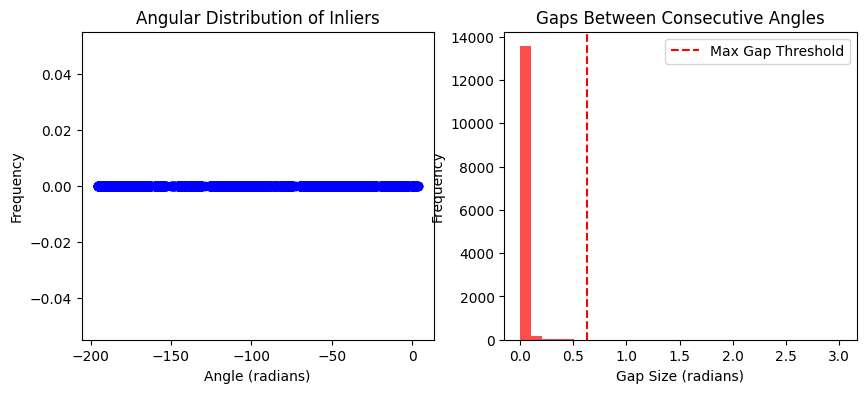

Iteration: 23
Number of inliers after filtering: 38 / 841


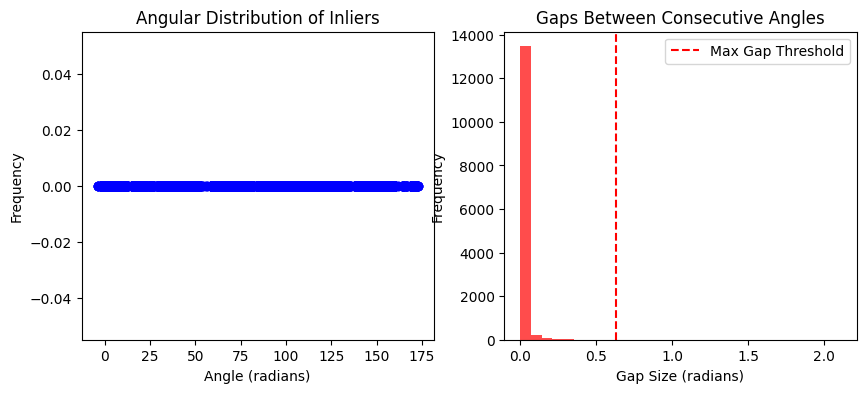

Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Number of inliers after filtering: 17 / 866


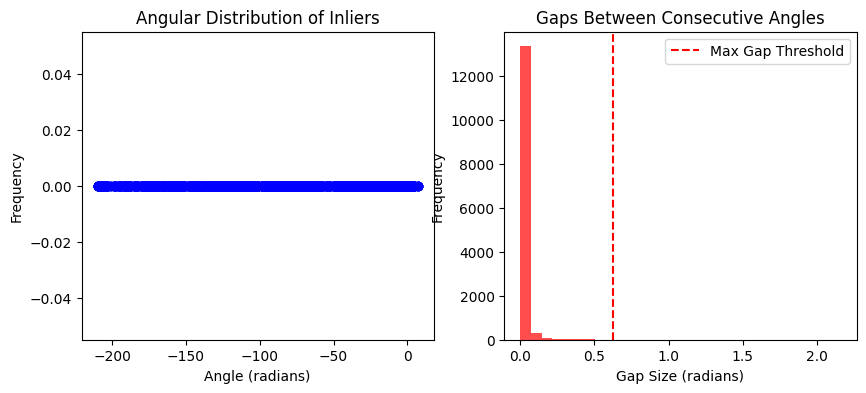

Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Number of inliers after filtering: 145 / 1370


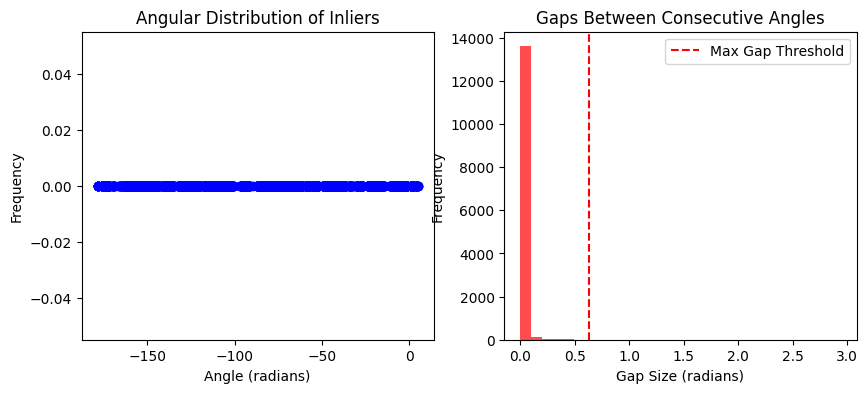

Iteration: 32
Iteration: 33
Number of inliers after filtering: 53 / 841


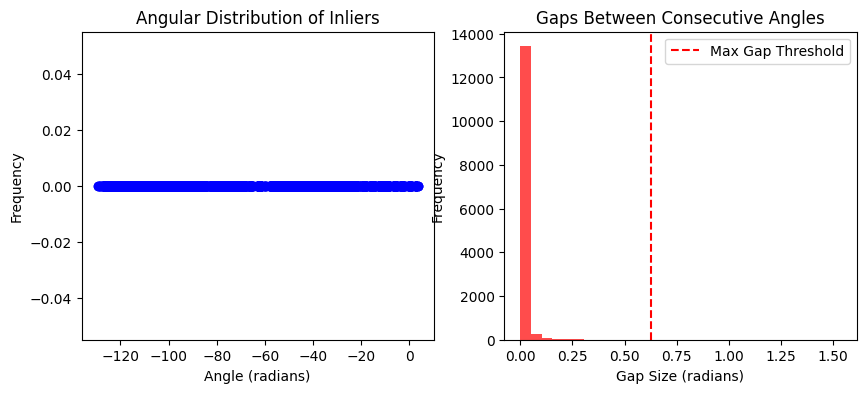

Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Number of inliers after filtering: 212 / 933


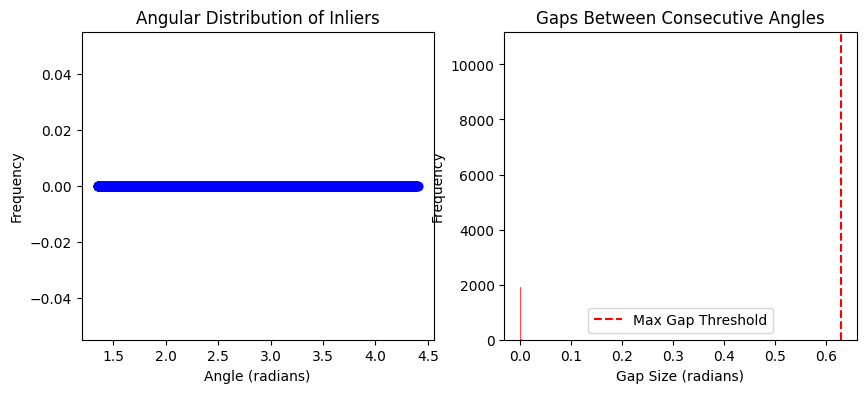

Insufficient angular coverage or clusters detected: Coverage = 174.97 degrees, Clusters = 1.
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Number of inliers after filtering: 248 / 1049


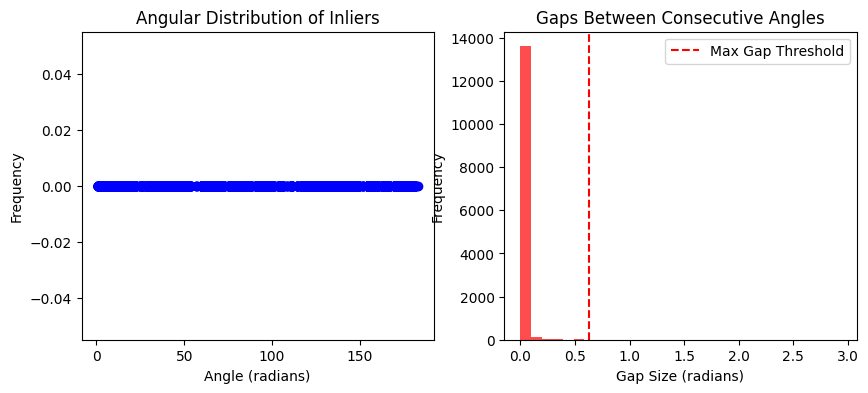

Iteration: 47
Iteration: 48
Number of inliers after filtering: 77 / 643


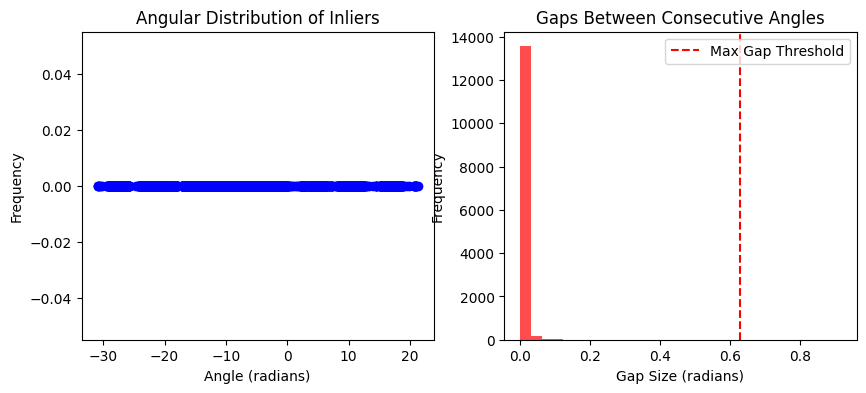

Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Number of inliers after filtering: 163 / 904


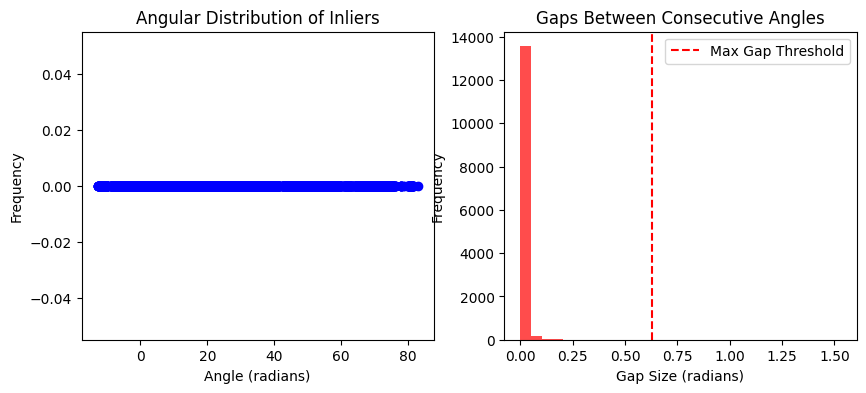

Iteration: 54
Number of inliers after filtering: 85 / 1102


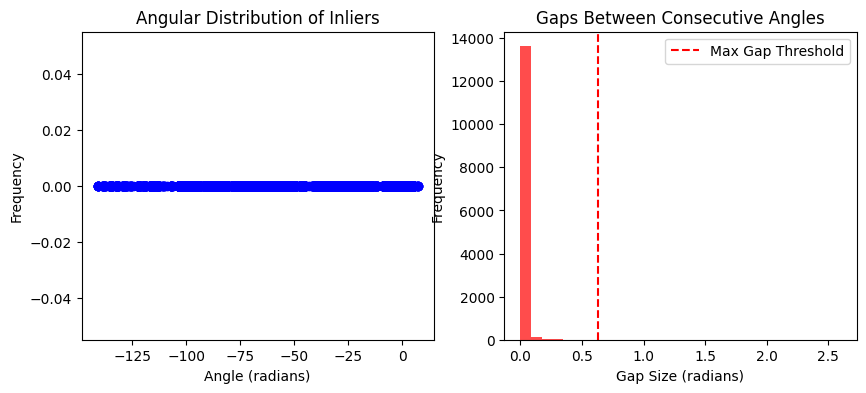

Iteration: 55
Iteration: 56
Iteration: 57
Number of inliers after filtering: 44 / 942


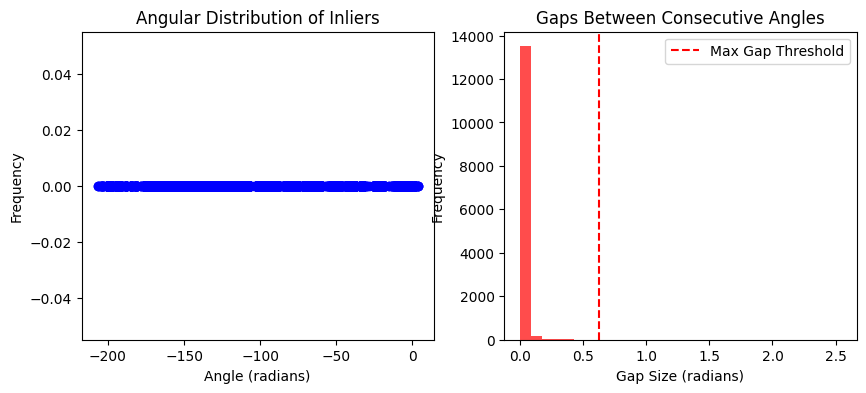

Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Number of inliers after filtering: 50 / 743


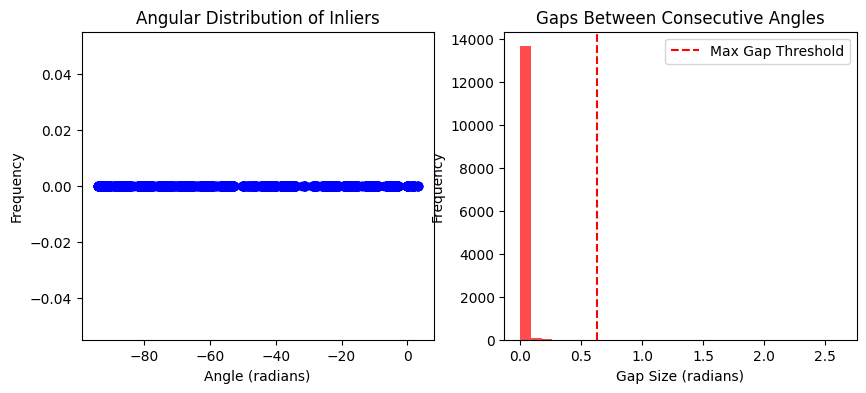

Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
Number of inliers after filtering: 9 / 468


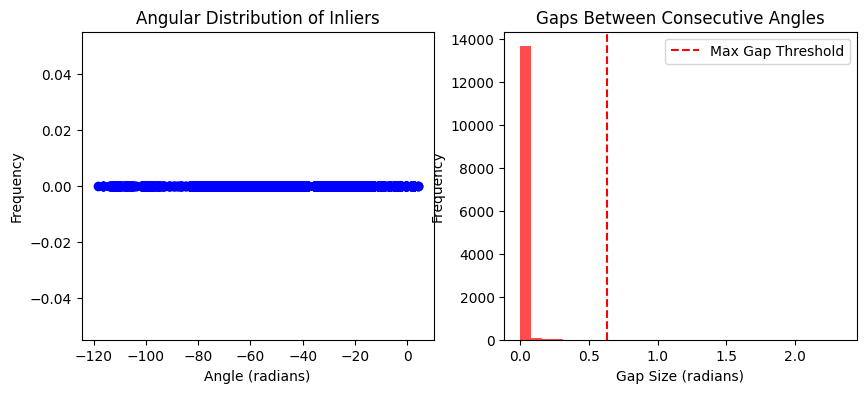

Iteration: 73
Iteration: 74
Iteration: 75
Number of inliers after filtering: 55 / 650


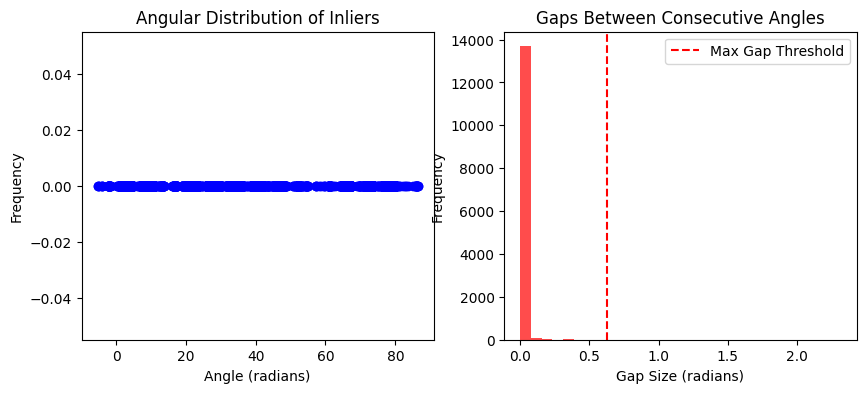

Iteration: 76
Iteration: 77
Number of inliers after filtering: 47 / 842


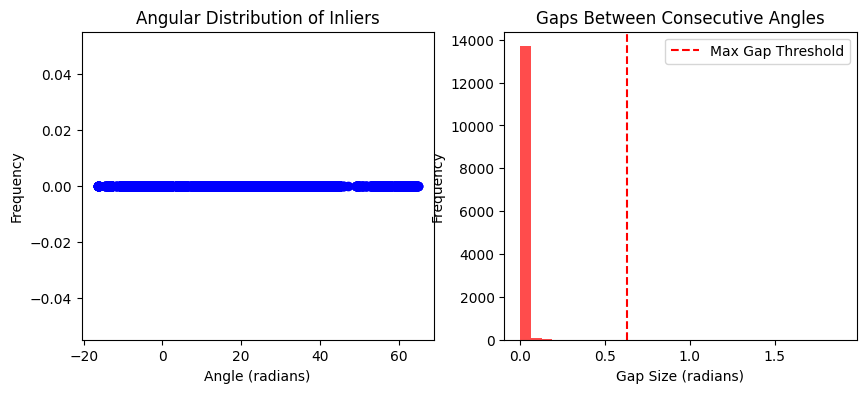

Iteration: 78
Iteration: 79
Iteration: 80
Iteration: 81
Number of inliers after filtering: 119 / 904


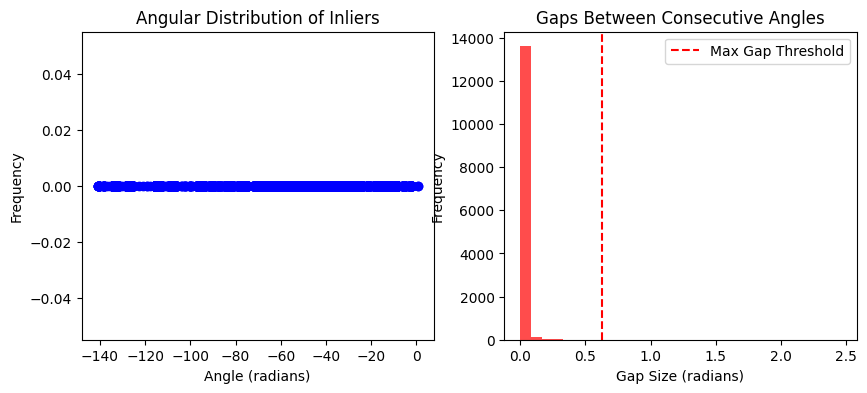

Iteration: 82
Iteration: 83
Iteration: 84
Iteration: 85
Iteration: 86
Iteration: 87
Iteration: 88
Iteration: 89
Number of inliers after filtering: 81 / 1245


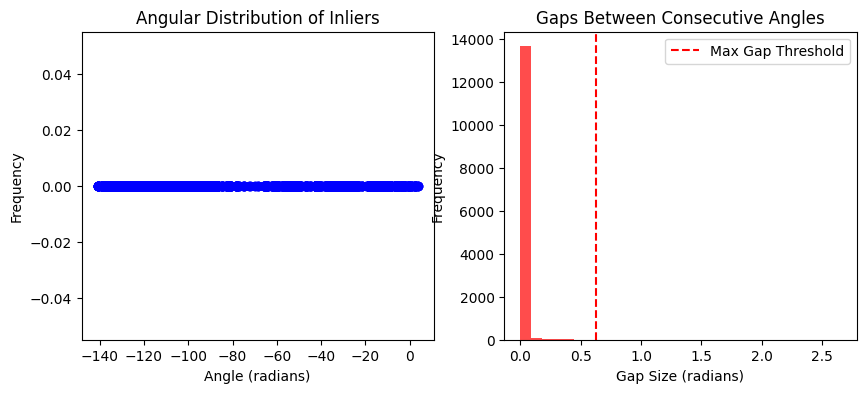

Iteration: 90
Number of inliers after filtering: 146 / 770


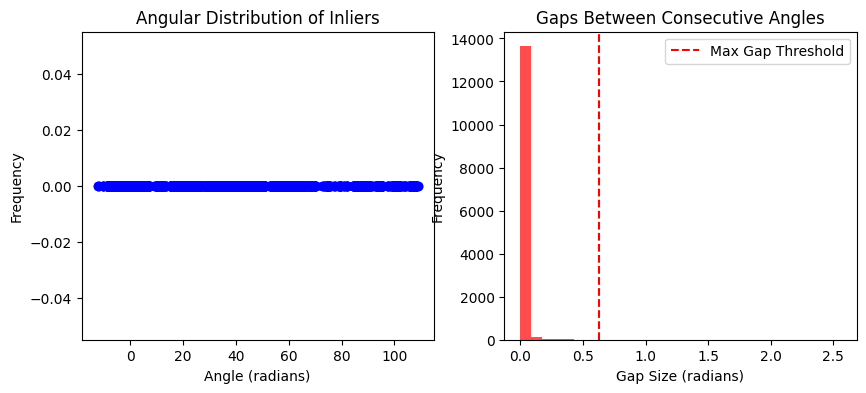

Iteration: 91
Number of inliers after filtering: 91 / 1051


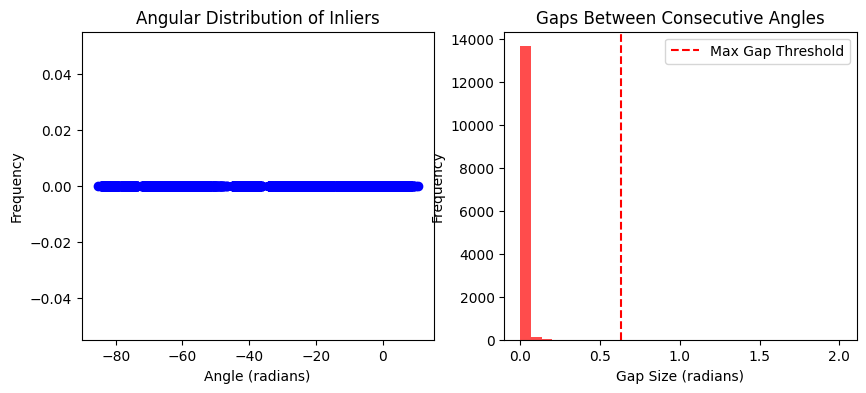

Iteration: 92
Number of inliers after filtering: 124 / 852


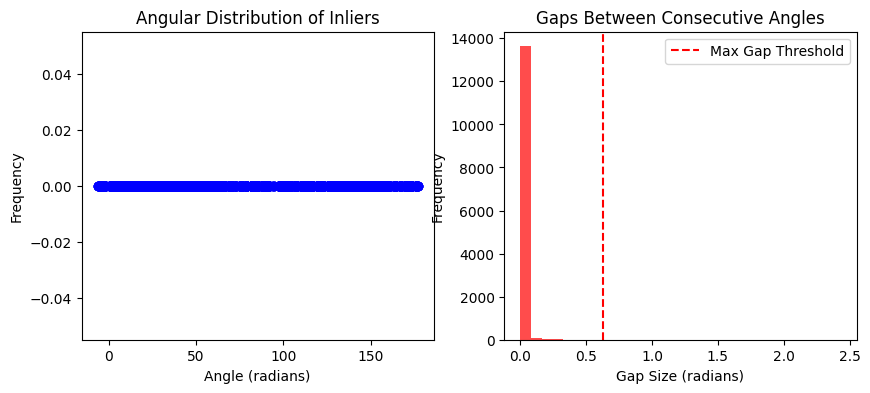

Iteration: 93
Iteration: 94
Iteration: 95
Iteration: 96
Number of inliers after filtering: 43 / 737


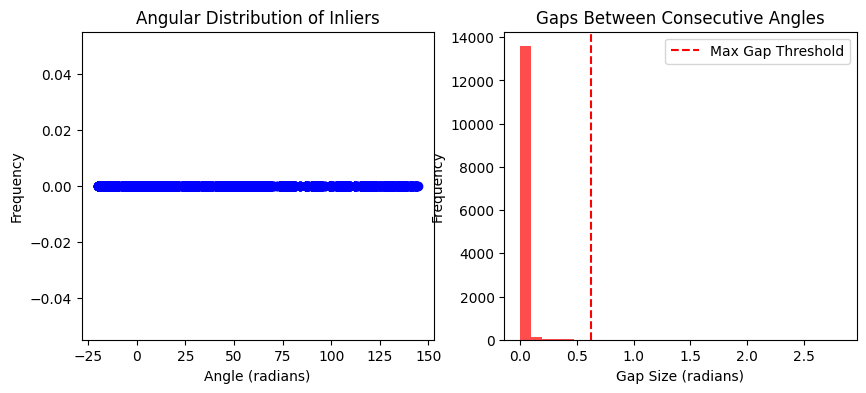

Iteration: 97
Iteration: 98
Iteration: 99
Number of inliers after filtering: 78 / 1053


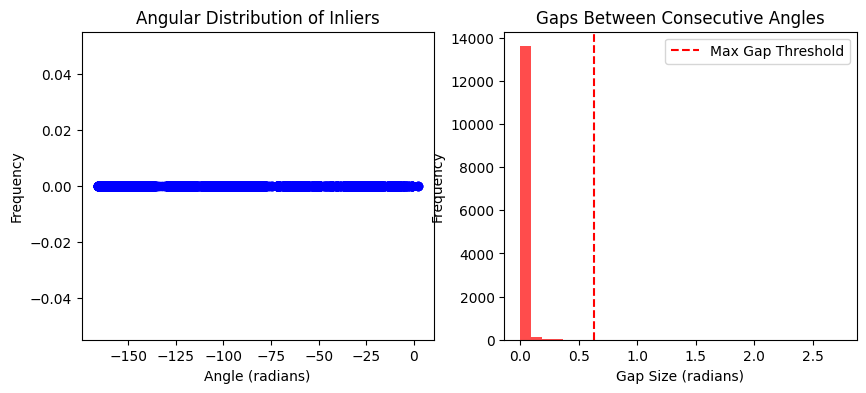

Iteration: 100
Number of inliers after filtering: 50 / 759


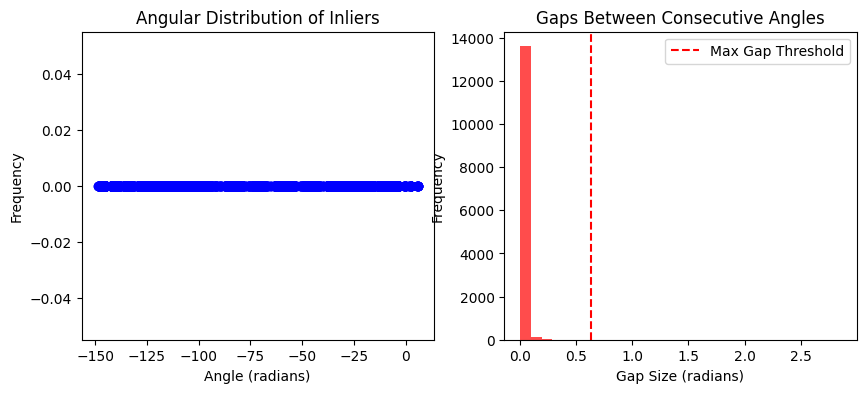

Best Score: 214.3804785578917, Inliers Count: 248


In [55]:
inlier_points, inlier_normals = ransac_cylinder(points, normals, threshold=0.003, iterations=100, min_radius=0.00, max_radius=0.06)

## Visualize results

In [56]:
plane_cloud = o3d.geometry.PointCloud()
plane_cloud.points = o3d.utility.Vector3dVector(inlier_normals)
plane_cloud.paint_uniform_color([0,1,0])

surface_cloud.paint_uniform_color([0,0,0])

o3d.visualization.draw_geometries([surface_cloud, plane_cloud], point_show_normal=True)